In [1]:
import os
from dotenv import load_dotenv
import os
import requests
import time
from PIL import Image
from io import BytesIO

load_dotenv(override=True)

# Đọc API Key từ biến môi trường
FREEPIK_API_KEY = "FPSXd011878d67fb41959fef879da510c691"
if not FREEPIK_API_KEY:
    print("❌ Lỗi: Chưa cài đặt biến môi trường FREEPIK_API_KEY!")
else:
    print("✅ API Key đã sẵn sàng!")

# Hàm chuẩn hóa tên file (loại bỏ ký tự đặc biệt)
def sanitize_filename(filename):
    return "".join(c if c.isalnum() or c in " _-" else "_" for c in filename)


✅ API Key đã sẵn sàng!


In [10]:
# Bước 1: Gửi yêu cầu tạo ảnh
# Bước 1: Gửi yêu cầu tạo ảnh với các tham số nâng cao
def create_image(
    prompt="robot",
    resolution="2k",  # 2k hoặc 4k
    aspect_ratio="square_1_1",  # Các tỷ lệ hình ảnh
    realism=True,  # True = Tăng độ chân thực, False = Giữ nguyên AI style
    creative_detailing=33,  # Mức độ chi tiết (0-100)
    engine="automatic"  # Chọn mô hình AI
):
    create_url = "https://api.freepik.com/v1/ai/text-to-image/flux-dev"
    
    # Xây dựng payload với các tham số đã cập nhật
    payload = {
        "prompt": prompt,
        "resolution": resolution,
        "aspect_ratio": aspect_ratio,
        "realism": realism,
        "creative_detailing": creative_detailing,
        "engine": engine
    }
    
    headers = {
        "x-freepik-api-key": FREEPIK_API_KEY,
        "Content-Type": "application/json"
    }

    # Gửi yêu cầu POST đến API Freepik AI
    response = requests.post(create_url, json=payload, headers=headers)

    if response.status_code == 200:
        data = response.json()
        task_id = data.get("data", {}).get("task_id")
        if task_id:
            print(f"✅ Ảnh đang được tạo! Task ID: {task_id}")
            return task_id
        else:
            print("❌ Không nhận được task_id! Kiểm tra lại API.")
    else:
        print(f"❌ Lỗi khi gửi yêu cầu tạo ảnh: {response.text}")
    return None


# Bước 2: Kiểm tra trạng thái ảnh
def check_status(task_id, max_retries=20, retry_delay=25):
    status_url = f"https://api.freepik.com/v1/ai/text-to-image/flux-dev/{task_id}"  
    headers = {"x-freepik-api-key": FREEPIK_API_KEY}
    
    start_time = time.time()
    
    for attempt in range(max_retries):
        elapsed_time = int(time.time() - start_time)
        response = requests.get(status_url, headers=headers)

        if response.status_code == 200:
            data = response.json()
            status = data.get("data", {}).get("status")

            if status == "COMPLETED":
                image_urls = data.get("data", {}).get("generated", [])
                if image_urls:
                    print(f"✅ Ảnh đã sẵn sàng sau {elapsed_time} giây! 🚀")
                    return image_urls[0]
                else:
                    print("❌ Ảnh không tồn tại dù trạng thái là COMPLETED.")
                    return None
            elif status == "FAILED":
                print("❌ Quá trình tạo ảnh thất bại.")
                return None
            else:
                print(f"⏳ Đang chờ ảnh... ({elapsed_time}s trôi qua, lần thử {attempt+1}/{max_retries})")
                time.sleep(retry_delay)
        elif response.status_code == 404:
            print(f"⚠️ Task ID chưa tồn tại ({elapsed_time}s). Có thể API cần thêm thời gian...")
            time.sleep(retry_delay)
        else:
            print(f"❌ Lỗi khi kiểm tra trạng thái ({response.status_code}): {response.text}")
            return None

    print("⏳ Hết số lần thử, ảnh có thể chưa được tạo hoàn tất.")
    return None

# Bước 3: Tải ảnh về máy
def download_image(image_url, prompt):
    filename = sanitize_filename(prompt)[:50] + ".jpg"  # Giới hạn tên file 50 ký tự
    response = requests.get(image_url)

    if response.status_code == 200:
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"📥 Ảnh đã được tải về: {filename}")

        # Hiển thị ảnh ngay trong Jupyter Notebook
        img = Image.open(BytesIO(response.content))
        display(img)
    else:
        print(f"❌ Lỗi khi tải ảnh: {response.status_code}")


✅ Ảnh đang được tạo! Task ID: 7c7a2055-4cae-4e0b-9e75-a9fcafcfad32
⏳ Đang chờ ảnh... (0s trôi qua, lần thử 1/20)
✅ Ảnh đã sẵn sàng sau 25 giây! 🚀
📥 Ảnh đã được tải về: A realistic illustration of an e-commerce workspac.jpg


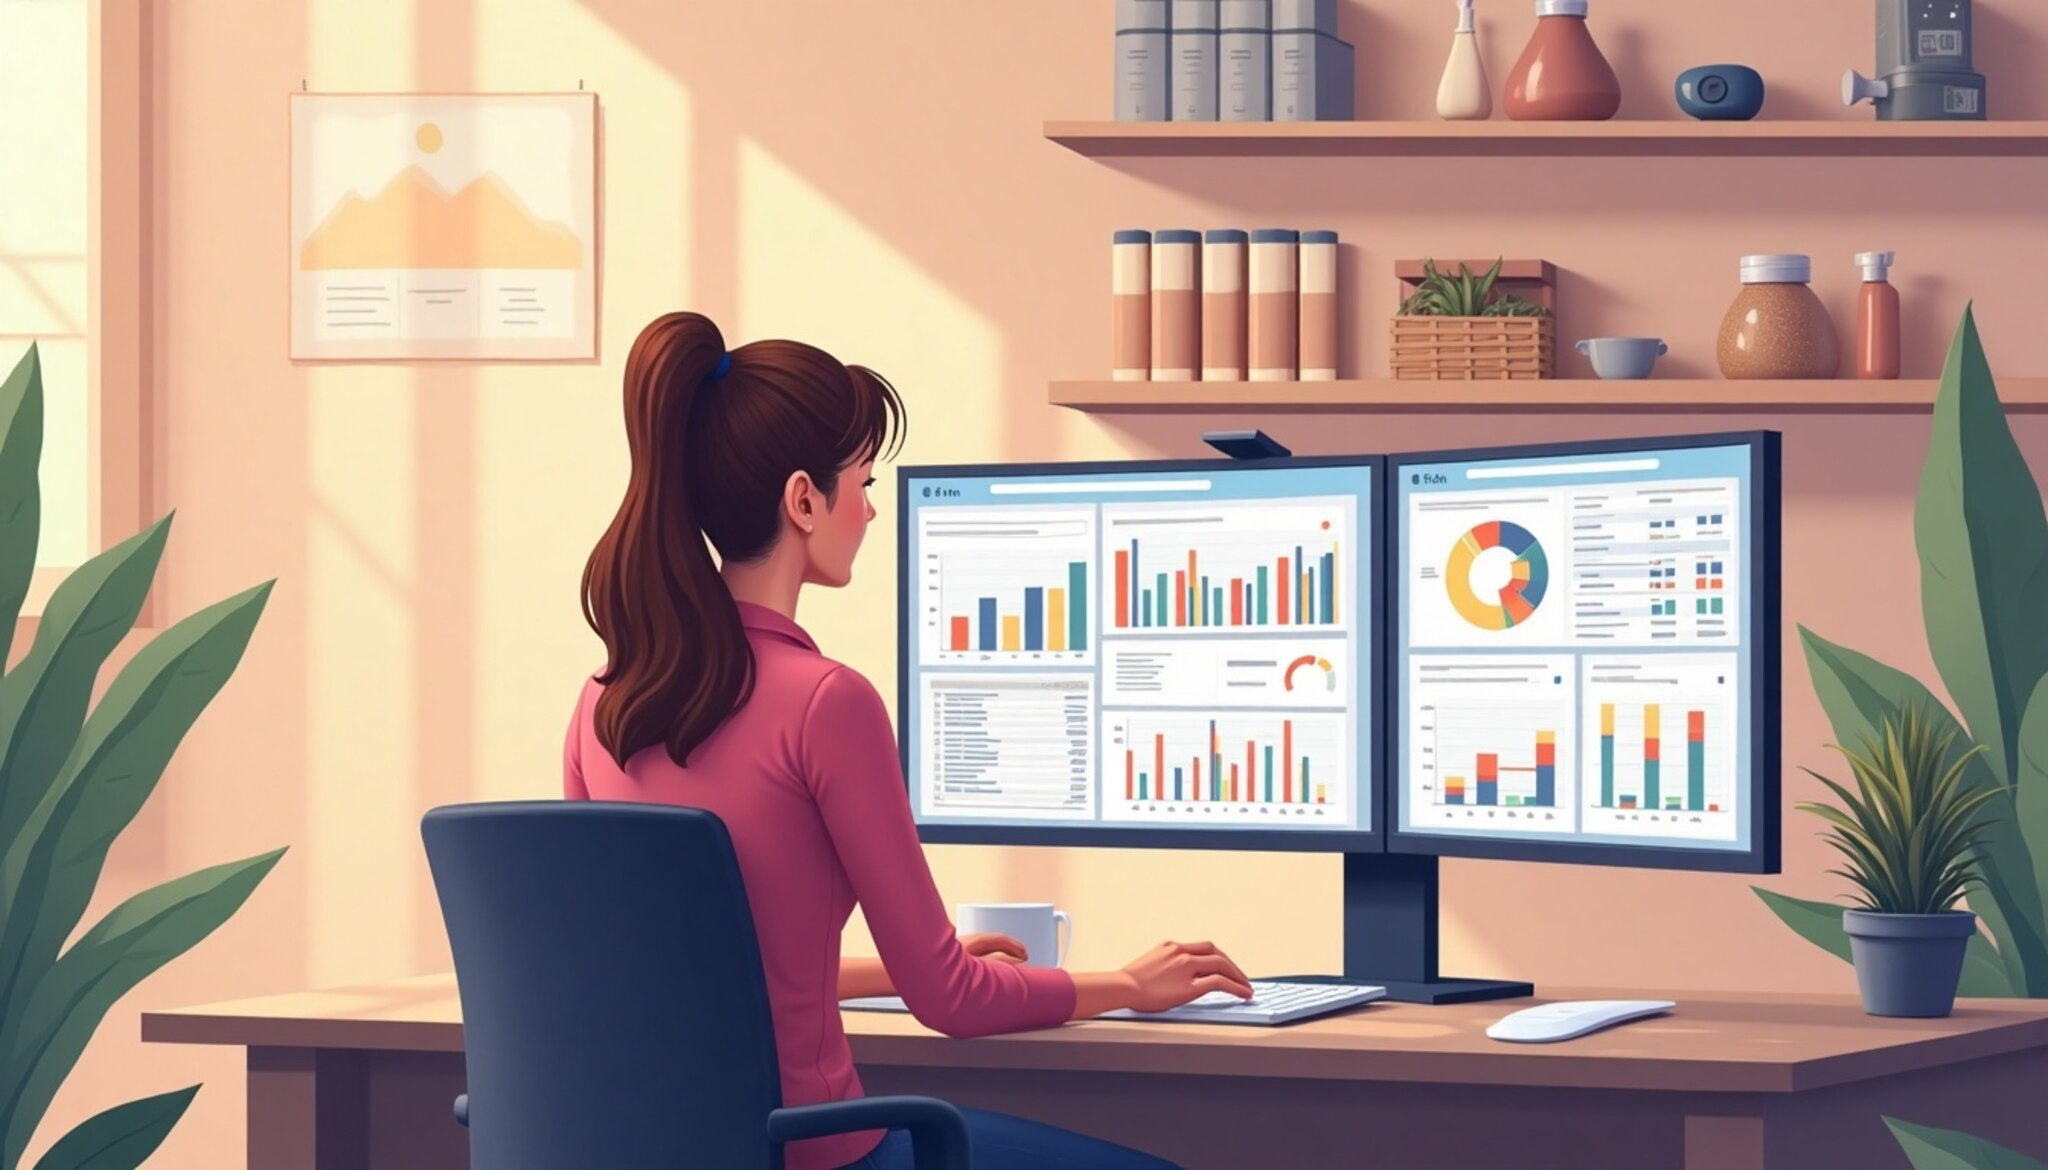

In [11]:
# Nhập prompt mới
prompt = "A realistic illustration of an e-commerce workspace, featuring a data analyst reviewing detailed charts and reports on a dual-monitor setup. The scene includes shelves with neatly arranged product samples, a warm, softly lit environment, and neutral-toned decor in a professional setting."# Tạo ảnh
task_id = create_image(
    prompt=prompt,
    resolution="2k",
    aspect_ratio="widescreen_16_9",
    realism=False,  # Làm cho ảnh chân thực hơn
    creative_detailing=25,  # Tăng mức độ chi tiết
    engine="magnific_illusio"  # Mô hình sắc nét nhất
)

if task_id:
    image_url = check_status(task_id)
    if image_url:
        download_image(image_url, prompt)
